In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

# Import models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#Import performance matrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


#%pip install vecstack

In [3]:
df = pd.read_csv("E:/Lakni UOC/4th Year/1st sem/ST 4052 - Statistical Learning II/2.grp project 1/codes_diabetes/diabetes_prediction_dataset.csv")

In [4]:
df_copy = df.copy()

In [5]:
df_copy.drop_duplicates(inplace=True)
print(f'without duplicates:{df_copy.shape}')

# Remove Unneccessary value [0.02%]
df2 = df_copy[df_copy['gender'] != 'Other']

# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status == 'never':
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'
    else:
        return 'no info'
    
# Apply the function to the 'smoking_history' column
df2['smoking_history'] = df2['smoking_history'].apply(recategorize_smoking)

#encoding
gender = {'Female':0,'Male':1}
df2['gender'] =df2['gender'].replace(gender)

def perform_one_hot_encoding(df2, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df2[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df2 = pd.concat([df2.drop(column_name, axis=1), dummies], axis=1)

    return df2

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(df2, 'smoking_history')
data.head()

without duplicates:(96146, 9)


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_no info,smoking_history_non-smoker,smoking_history_past_smoker
0,0,80.00,0,1,25.19,6.60,140,0,0,0,1,0
1,0,54.00,0,0,27.32,6.60,80,0,0,1,0,0
2,1,28.00,0,0,27.32,5.70,158,0,0,0,1,0
3,0,36.00,0,0,23.45,5.00,155,0,1,0,0,0
4,1,76.00,1,1,20.14,4.80,155,0,1,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96128 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       96128 non-null  int64  
 1   age                          96128 non-null  float64
 2   hypertension                 96128 non-null  int64  
 3   heart_disease                96128 non-null  int64  
 4   bmi                          96128 non-null  float64
 5   HbA1c_level                  96128 non-null  float64
 6   blood_glucose_level          96128 non-null  int64  
 7   diabetes                     96128 non-null  int64  
 8   smoking_history_current      96128 non-null  uint8  
 9   smoking_history_no info      96128 non-null  uint8  
 10  smoking_history_non-smoker   96128 non-null  uint8  
 11  smoking_history_past_smoker  96128 non-null  uint8  
dtypes: float64(3), int64(5), uint8(4)
memory usage: 7.0 MB


In [7]:
int_cols = ['gender','hypertension','heart_disease','diabetes','smoking_history_current','smoking_history_no info','smoking_history_non-smoker','smoking_history_past_smoker']

for col in int_cols:
    data[col] = data[col].astype('category')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96128 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   gender                       96128 non-null  category
 1   age                          96128 non-null  float64 
 2   hypertension                 96128 non-null  category
 3   heart_disease                96128 non-null  category
 4   bmi                          96128 non-null  float64 
 5   HbA1c_level                  96128 non-null  float64 
 6   blood_glucose_level          96128 non-null  int64   
 7   diabetes                     96128 non-null  category
 8   smoking_history_current      96128 non-null  category
 9   smoking_history_no info      96128 non-null  category
 10  smoking_history_non-smoker   96128 non-null  category
 11  smoking_history_past_smoker  96128 non-null  category
dtypes: category(8), float64(3), int64(1)
memory usage: 4.4 MB


## split the dataset

In [8]:
x = data.drop(['diabetes',"smoking_history_no info"],axis=1)
y = data["diabetes"]
x.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_current,smoking_history_non-smoker,smoking_history_past_smoker
0,0,80.00,0,1,25.19,6.60,140,0,1,0
1,0,54.00,0,0,27.32,6.60,80,0,0,0
2,1,28.00,0,0,27.32,5.70,158,0,1,0
3,0,36.00,0,0,23.45,5.00,155,1,0,0
4,1,76.00,1,1,20.14,4.80,155,1,0,0


# Feature Importance Plot

In [9]:
x_column_names = x.columns.tolist()
x_column_names

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'smoking_history_current',
 'smoking_history_non-smoker',
 'smoking_history_past_smoker']

In [10]:
train_feature, test_feature, train_label, test_label = train_test_split(x, y, test_size=0.2, random_state=42)
train_feature.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_current,smoking_history_non-smoker,smoking_history_past_smoker
39756,0,8.00,0,0,15.90,3.50,90,0,0,0
75304,1,65.00,1,1,28.49,8.80,145,0,1,0
19765,1,64.00,1,0,33.69,4.80,80,0,0,0
97291,1,49.00,0,0,21.84,5.00,130,0,1,0
37660,0,26.00,0,0,21.95,5.70,158,0,1,0


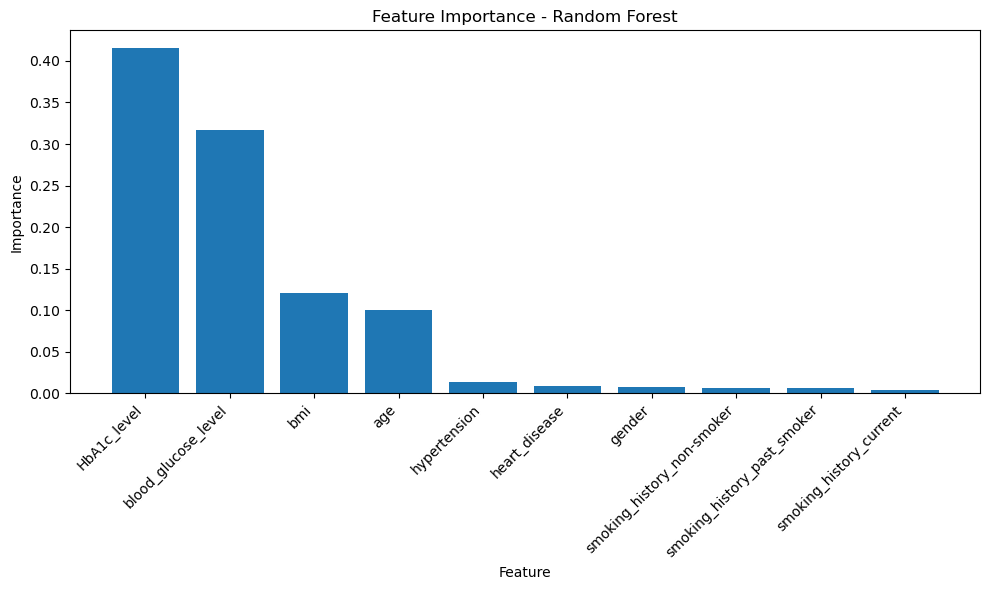

In [11]:

# Create and fit the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(train_feature, train_label)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Sort features and importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [x_column_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_names)), sorted_importances, align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

## dropping least important variables and refit

In [12]:
train_feature = train_feature.drop(["smoking_history_non-smoker","smoking_history_past_smoker",'smoking_history_current','heart_disease','gender','hypertension'],axis=1)
test_feature = test_feature.drop(["smoking_history_non-smoker","smoking_history_past_smoker",'smoking_history_current','heart_disease','gender','hypertension'],axis=1)


In [13]:
train_feature.head()

,age,bmi,HbA1c_level,blood_glucose_level
39756,8.00,15.90,3.50,90
75304,65.00,28.49,8.80,145
19765,64.00,33.69,4.80,80
97291,49.00,21.84,5.00,130
37660,26.00,21.95,5.70,158


## Reduced models without hyperparameter tuning

In [55]:


models = {
    'Multiple Logistic': LogisticRegression(solver='liblinear'),
    'Ridge': LogisticRegression(penalty='l2', C=1.0),
    'Lasso': LogisticRegression(penalty='l1', C=1, solver='liblinear'),
    'Elastic-net':LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1, solver='saga'),
    'Random Forest': RandomForestClassifier(),
    'GausianNB': GaussianNB(),
    'XGBoost': XGBClassifier()
}

# Create an OneHotEncoder instance
#encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and transform the encoder on your categorical columns
#train_cat_encoded = encoder.fit_transform(train_feature[categorical_cols])
#test_cat_encoded = encoder.transform(test_feature[categorical_cols])

# Concatenate the encoded categorical features with the numeric features
#train_encoded = np.concatenate((train_cat_encoded, train_feature[numeric_cols]), axis=1)
#test_encoded = np.concatenate((test_cat_encoded, test_feature[numeric_cols]), axis=1)

for name, model in models.items():
    print(name)
    print('=' * len(name))

    # Fit the model on the encoded data
    model.fit(train_feature, train_label)
    
     # Training set
    train_pred = model.predict(train_feature)
    train_acc = accuracy_score(train_label, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(train_label, train_pred, average='weighted')
    train_cm = confusion_matrix(train_label, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])

    
    # Test set
    test_pred = model.predict(test_feature)
    test_acc = accuracy_score(test_label, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(test_label, test_pred, average='weighted')
    test_cm = confusion_matrix(test_label, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])


    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print("Training sensitivity: ", train_sensitivity)
    print("Training specificity: ", train_specificity)
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print("Test sensitivity: ", test_sensitivity)
    print("Test specificity: ", test_specificity)

    print('\n\n')
    

Multiple Logistic
Training Accuracy: 0.9590
Training Error Rate: 0.0410
Training F1 Score: 0.9555
Training Confusion Matrix:
[[69624   497]
 [ 2653  4128]]
Training sensitivity:  0.6087597699454358
Training specificity:  0.9929122516792401


Test Accuracy: 0.9569
Test Error Rate: 0.0431
Test F1 Score: 0.9530
Test Confusion Matrix:
[[17387   138]
 [  691  1010]]
Test sensitivity:  0.5937683715461494
Test specificity:  0.9921255349500713



Ridge
=====
Training Accuracy: 0.9590
Training Error Rate: 0.0410
Training F1 Score: 0.9557
Training Confusion Matrix:
[[69537   584]
 [ 2571  4210]]
Training sensitivity:  0.6208523816546232
Training specificity:  0.9916715391965317


Test Accuracy: 0.9568
Test Error Rate: 0.0432
Test F1 Score: 0.9532
Test Confusion Matrix:
[[17372   153]
 [  677  1024]]
Test sensitivity:  0.6019988242210464
Test specificity:  0.9912696148359487



Lasso
=====
Training Accuracy: 0.9592
Training Error Rate: 0.0408
Training F1 Score: 0.9559
Training Confusion Matrix:
[

## Reduced models hyperp. tuning in random forest

In [15]:
import time

models = {
    'Multiple Logistic': LogisticRegression(solver='liblinear'),
    'Ridge': LogisticRegression(penalty='l2', C=1.0),
    'Lasso': LogisticRegression(penalty='l1', C=1, solver='liblinear'),
    'Elastic-net':LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1, solver='saga'),
    'Random Forest': RandomForestClassifier(),
    'GausianNB': GaussianNB(),
    'XGBoost': XGBClassifier()
}


for name, model in models.items():
    print(name)
    print('=' * len(name))

    if name == 'Random Forest':
        param_grid = {
            'min_samples_split': [2, 5, 10],
            'max_depth': [None, 10, 20],
            'n_estimators': [50, 100, 200]
        }
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(train_feature, train_label)
        best_model = grid_search.best_estimator_
        model = best_model

    # Fit the model on the encoded data & # Calculate the time taken to fit the model on the training data
    start_time = time.time()
    model.fit(train_feature, train_label)
    end_time = time.time()
    train_time = end_time - start_time

    
     # Training set
    train_pred = model.predict(train_feature)
    train_acc = accuracy_score(train_label, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(train_label, train_pred, average='weighted')
    train_cm = confusion_matrix(train_label, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])

    # Test set
    test_pred = model.predict(test_feature)
    test_acc = accuracy_score(test_label, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(test_label, test_pred, average='weighted')
    test_cm = confusion_matrix(test_label, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])

    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print("Training sensitivity: ", train_sensitivity)
    print("Training specificity: ", train_specificity)
    print("Training time: ", train_time)
    print("Training ROC AUC: ", '{:.2%}'.format(roc_auc_score(train_label, train_pred)))
    print(classification_report(train_label, train_pred))
    print(f'Training Confusion Matrix:\n{train_cm}')
    print('\n')
    
    
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print("Test sensitivity: ", test_sensitivity)
    print("Test specificity: ", test_specificity)
    print("Test ROC AUC: ", '{:.2%}'.format(roc_auc_score(test_label, test_pred)))
    print(classification_report(test_label, test_pred))
    print(f'Test Confusion Matrix:\n{test_cm}')

    print('\n\n')


Multiple Logistic
Training Accuracy: 0.9590
Training Error Rate: 0.0410
Training F1 Score: 0.9555
Training sensitivity:  0.6087597699454358
Training specificity:  0.9929122516792401
Training time:  1.0316963195800781
Training ROC AUC:  80.08%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     70121
           1       0.89      0.61      0.72      6781

    accuracy                           0.96     76902
   macro avg       0.93      0.80      0.85     76902
weighted avg       0.96      0.96      0.96     76902

Training Confusion Matrix:
[[69624   497]
 [ 2653  4128]]


Test Accuracy: 0.9569
Test Error Rate: 0.0431
Test F1 Score: 0.9530
Test sensitivity:  0.5937683715461494
Test specificity:  0.9921255349500713
Test ROC AUC:  79.29%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17525
           1       0.88      0.59      0.71      1701

    accuracy                           0

In [16]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


## Class wise performance matrics

Multiple Logistic
Ridge
=====
Lasso
=====
Elastic-net
Random Forest
GaussianNB
XGBoost


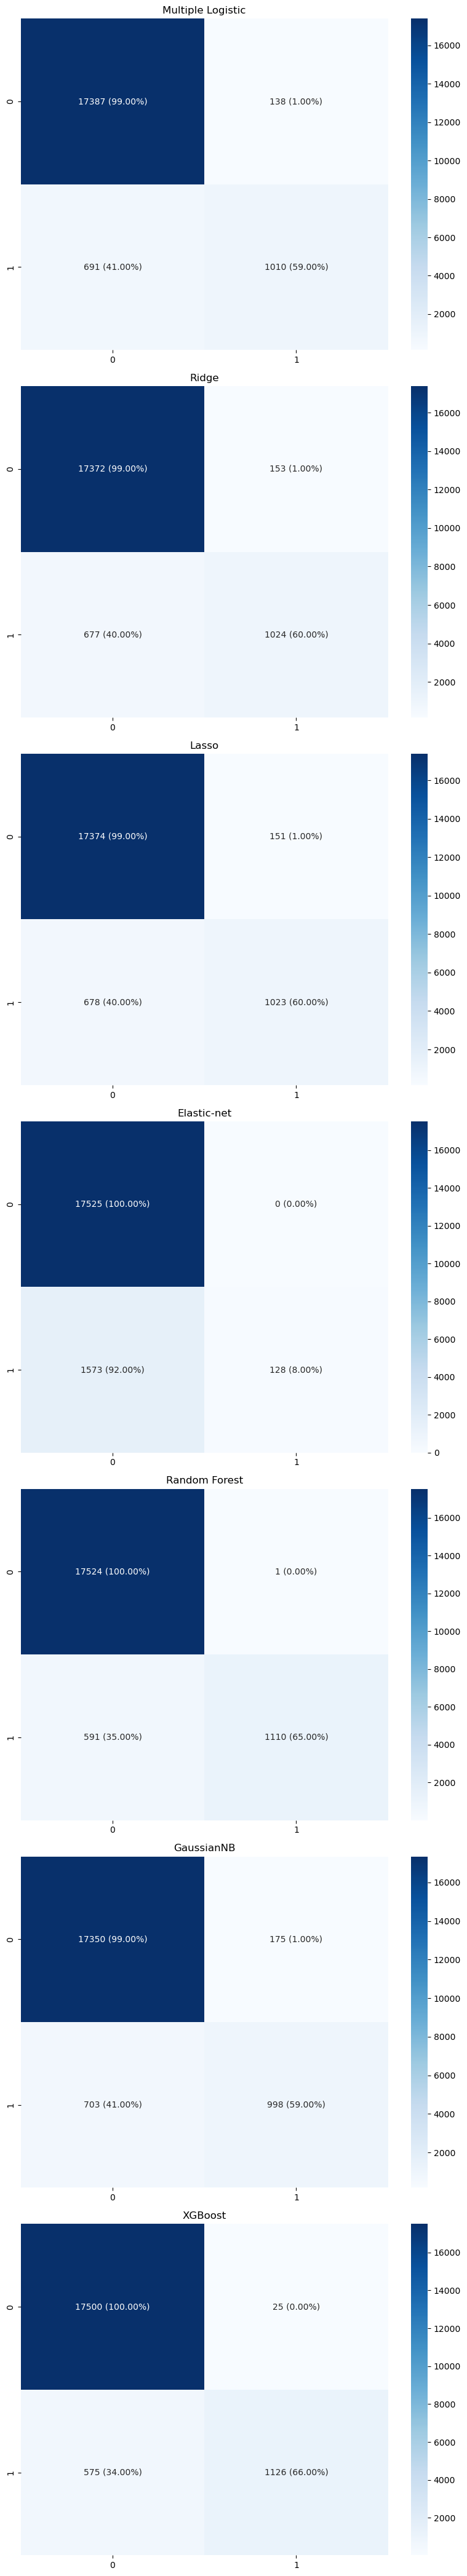

In [18]:


# Assuming you have your train_feature, train_label, test_feature, and test_label defined

models = {
    'Multiple Logistic': LogisticRegression(solver='liblinear'),
    'Ridge': LogisticRegression(penalty='l2', C=1.0),
    'Lasso': LogisticRegression(penalty='l1', C=1, solver='liblinear'),
    'Elastic-net': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1, solver='saga'),
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50),
    'GaussianNB': GaussianNB(),
    'XGBoost': XGBClassifier()
}

# Create subplots for each model
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 6 * len(models)))

for i, (name, model) in enumerate(models.items()):
    print(name)
    print('=' * len(name))

    # Fit the model on the encoded data
    model.fit(train_feature, train_label)
    
    test_pred = model.predict(test_feature)
    
    # Calculate confusion matrix for test data
    test_c_matrix = confusion_matrix(test_label, test_pred)
    
    # Calculate label percentages and create label strings with counts and percentages for test data
    test_percentages = (test_c_matrix / np.sum(test_c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    test_labels = [[f"{test_c_matrix[i, j]} ({test_percentages[i, j]:.2f}%)" for j in range(test_c_matrix.shape[1])] for i in range(test_c_matrix.shape[0])]
    test_labels = np.asarray(test_labels)
    
    # Plot confusion matrix with labeled counts and percentages for test data
    sns.heatmap(test_c_matrix, annot=test_labels, fmt='', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)

# Move these lines outside the loop
plt.tight_layout()
plt.show()


## Reduced models with hyperp. tuning in xgboosting

In [19]:

models = {
    'Multiple Logistic': LogisticRegression(solver='liblinear'),
    'Ridge': LogisticRegression(penalty='l2', C=1.0),
    'Lasso': LogisticRegression(penalty='l1', C=1, solver='liblinear'),
    'Elastic-net':LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1, solver='saga'),
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50),
    'GausianNB': GaussianNB(),
    'XGBoost': XGBClassifier()
}


for name, model in models.items():
    print(name)
    print('=' * len(name))

    if name == 'XGBoost':
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.01, 0.001],
            'n_estimators': [100, 200, 300],
            'subsample' :[0.8, 0.9, 1.0]
        }
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(train_feature, train_label)
        best_model = grid_search.best_estimator_
        model = best_model

    # Fit the model on the encoded data
    # Calculate the time taken to fit the model on the training data
    start_time = time.time()
    model.fit(train_feature, train_label)
    end_time = time.time()
    train_time = end_time - start_time
   
    
     # Training set
    train_pred = model.predict(train_feature)
    train_acc = accuracy_score(train_label, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(train_label, train_pred, average='weighted')
    train_cm = confusion_matrix(train_label, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])

    # Test set
    test_pred = model.predict(test_feature)
    test_acc = accuracy_score(test_label, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(test_label, test_pred, average='weighted')
    test_cm = confusion_matrix(test_label, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])

    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print("Training sensitivity: ", train_sensitivity)
    print("Training specificity: ", train_specificity)
    print("Training time: ", train_time)
    print("Training ROC AUC: ", '{:.2%}'.format(roc_auc_score(train_label, train_pred)))
    print(classification_report(train_label, train_pred))
    print(f'Training Confusion Matrix:\n{train_cm}')
    print('\n')
    
    
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print("Test sensitivity: ", test_sensitivity)
    print("Test specificity: ", test_specificity)
    print("Test ROC AUC: ", '{:.2%}'.format(roc_auc_score(test_label, test_pred)))
    print(classification_report(test_label, test_pred))
    print(f'Test Confusion Matrix:\n{test_cm}')

    print('\n\n')


Multiple Logistic
Training Accuracy: 0.9590
Training Error Rate: 0.0410
Training F1 Score: 0.9555
Training sensitivity:  0.6087597699454358
Training specificity:  0.9929122516792401
Training time:  0.35851216316223145
Training ROC AUC:  80.08%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     70121
           1       0.89      0.61      0.72      6781

    accuracy                           0.96     76902
   macro avg       0.93      0.80      0.85     76902
weighted avg       0.96      0.96      0.96     76902

Training Confusion Matrix:
[[69624   497]
 [ 2653  4128]]


Test Accuracy: 0.9569
Test Error Rate: 0.0431
Test F1 Score: 0.9530
Test sensitivity:  0.5937683715461494
Test specificity:  0.9921255349500713
Test ROC AUC:  79.29%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17525
           1       0.88      0.59      0.71      1701

    accuracy                           

In [20]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}


# ensemble technique - stacking

1. Stacking: It is an ensemble method that combines multiple models (classification or regression) via meta-model (meta-classifier or meta-regression). The base models are trained on the complete dataset, then the meta-model is trained on features returned (as output) from base models. The base models in stacking are typically different. The meta-model helps to find the features from base models to achieve the best accuracy.
    
    Stacking is a bit different from the basic ensembling methods because it has first-level and second-level models. Stacking features are first extracted by training the dataset with all the first-level models. A first-level model is then using the train stacking features to train the model than this model predicts the final output with test stacking features.

Algorithm:

        Split the train dataset into n parts
        A base model (say linear regression) is fitted on n-1 parts and predictions are made for the nth part. This is done for each one of the n part of the train set.
        The base model is then fitted on the whole train dataset.
        This model is used to predict the test dataset.
        The Steps 2 to 4 are repeated for another base model which results in another set of predictions for the train and test dataset.
        The predictions on train data set are used as a feature to build the new model.
        This final model is used to make the predictions on test dataset
        
https://www.geeksforgeeks.org/ensemble-methods-in-python/

In [75]:
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from vecstack import stacking


# Train XGBoost and Random Forest models
xgb_model = XGBClassifier(learning_rate= 0.1, max_depth = 3, n_estimators = 200)
rf_model = RandomForestClassifier(max_depth= 10, min_samples_split= 5, n_estimators= 50)
lr_model = LogisticRegression(solver='liblinear')

# Create a stacking model with a meta-model (Logistic Regression)
models = [xgb_model, rf_model, lr_model]
meta_model = LogisticRegression(solver='liblinear')

# Perform stacking to generate ensemble predictions
S_train, S_test = stacking(models, train_feature, train_label, test_feature,
                           regression=False, metric=accuracy_score,
                           n_folds=5, shuffle=True, random_state=42,
                           verbose=2)

# Train the meta-model on the stacked predictions
meta_model.fit(S_train, train_label)

# Ensemble predictions using the meta-model
ensemble_train_preds = meta_model.predict(S_train)
ensemble_test_preds = meta_model.predict(S_test)

# Calculate accuracy
ensemble_train_acc = accuracy_score(train_label, ensemble_train_preds)
ensemble_test_acc = accuracy_score(test_label, ensemble_test_preds)

print("Ensemble Train Accuracy:", ensemble_train_acc)
print("Ensemble Test Accuracy:", ensemble_test_acc)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    fold  0:  [0.97178337]
    fold  1:  [0.97126325]
    fold  2:  [0.96872562]
    fold  3:  [0.97204161]
    fold  4:  [0.97210663]
    ----
    MEAN:     [0.97118410] + [0.00126459]
    FULL:     [0.97118410]

model  1:     [RandomForestClassifier]
    fold  0:  [0.97197841]
    fold  1:  [0.97113322]
    fold  2:  [0.96859558]
    fold  3:  [0.97184655]
    fold  4:  [0.97184655]
    ----
    MEAN:     [0.97108006] + [0.00127731]
    FULL:     [0.97108008]

model  2:     [LogisticRegression]
    fold  0:  [0.96001560]
    fold  1:  [0.96073077]
    fold  2:  [0.95669701]
    fold  3:  [0.95864759]
    fold  4:  [0.95955787]
    ----
    MEAN:     [0.95912977] + [0.00139155]
    FULL:     [0.95912980]

Ensemble Train Accuracy: 0.9711841044446178
Ensemble Test Accuracy: 0.9694164152709872


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from vecstack import stacking


# Train XGBoost and Random Forest models
xgb_model = XGBClassifier()
rf_model = RandomForestClassifier()
lr_model = LogisticRegression()

# Create a stacking model with a meta-model (Logistic Regression)
models = [xgb_model, rf_model, lr_model]
meta_model = LogisticRegression()

# Perform stacking to generate ensemble predictions
S_train, S_test = stacking(models, train_encoded, train_label, test_encoded,
                           regression=False, metric=accuracy_score,
                           n_folds=5, shuffle=True, random_state=42,
                           verbose=2)

# Train the meta-model on the stacked predictions
meta_model.fit(S_train, train_label)

# Ensemble predictions using the meta-model
ensemble_train_preds = meta_model.predict(S_train)
ensemble_test_preds = meta_model.predict(S_test)

# Calculate accuracy
ensemble_train_acc = accuracy_score(train_label, ensemble_train_preds)
ensemble_test_acc = accuracy_score(test_label, ensemble_test_preds)

print("Ensemble Train Accuracy:", ensemble_train_acc)
print("Ensemble Test Accuracy:", ensemble_test_acc)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    fold  0:  [0.97048306]
    fold  1:  [0.97048306]
    fold  2:  [0.96827048]
    fold  3:  [0.97145644]
    fold  4:  [0.97015605]
    ----
    MEAN:     [0.97016982] + [0.00104492]
    FULL:     [0.97016983]

model  1:     [RandomForestClassifier]
    fold  0:  [0.96879267]
    fold  1:  [0.96814251]
    fold  2:  [0.96644993]
    fold  3:  [0.97093628]
    fold  4:  [0.96957087]
    ----
    MEAN:     [0.96877845] + [0.00149069]
    FULL:     [0.96877845]

model  2:     [LogisticRegression]
    fold  0:  [0.95351408]
    fold  1:  [0.95364411]
    fold  2:  [0.95539662]
    fold  3:  [0.95682705]
    fold  4:  [0.95942783]
    ----
    MEAN:     [0.95576194] + [0.00220203]
    FULL:     [0.95576188]

Ensemble Train Accuracy: 0.9705859405477101
Ensemble Test Accuracy: 0.9685321959846042


In [16]:
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from vecstack import stacking


# Train XGBoost and Random Forest models
xgb_model = XGBClassifier()
rf_model = RandomForestClassifier()
llr_model = LogisticRegression(penalty='l1', C=1, solver='liblinear')

# Create a stacking model with a meta-model (Logistic Regression)
models = [xgb_model, rf_model, llr_model]
meta_model = LogisticRegression(penalty='l1', C=1, solver='liblinear')

# Perform stacking to generate ensemble predictions
S_train, S_test = stacking(models, train_encoded, train_label, test_encoded,
                           regression=False, metric=accuracy_score,
                           n_folds=5, shuffle=True, random_state=42,
                           verbose=2)

# Train the meta-model on the stacked predictions
meta_model.fit(S_train, train_label)

# Ensemble predictions using the meta-model
ensemble_train_preds = meta_model.predict(S_train)
ensemble_test_preds = meta_model.predict(S_test)

# Calculate accuracy
ensemble_train_acc = accuracy_score(train_label, ensemble_train_preds)
ensemble_test_acc = accuracy_score(test_label, ensemble_test_preds)

print("Ensemble Train Accuracy:", ensemble_train_acc)
print("Ensemble Test Accuracy:", ensemble_test_acc)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    fold  0:  [0.97048306]
    fold  1:  [0.97048306]
    fold  2:  [0.96827048]
    fold  3:  [0.97145644]
    fold  4:  [0.97015605]
    ----
    MEAN:     [0.97016982] + [0.00104492]
    FULL:     [0.97016983]

model  1:     [RandomForestClassifier]
    fold  0:  [0.96937780]
    fold  1:  [0.96788245]
    fold  2:  [0.96612484]
    fold  3:  [0.97106632]
    fold  4:  [0.96879064]
    ----
    MEAN:     [0.96864841] + [0.00163424]
    FULL:     [0.96864841]

model  2:     [LogisticRegression]
    fold  0:  [0.96060074]
    fold  1:  [0.96008062]
    fold  2:  [0.95747724]
    fold  3:  [0.95845254]
    fold  4:  [0.95988296]
    ----
    MEAN:     [0.95929882] + [0.00115601]
    FULL:     [0.95929885]

Ensemble Train Accuracy: 0.9706379547996151
Ensemble Test Accuracy: 0.9687402475814002


In [17]:
0.9712231151335466-0.9691043378757932 #xgb with hyperpara

0.002118777257753446

In [22]:
0.9712751293854516- 0.9691563507749922 ##log(solver='liblinear') + #xgb with hyperpara

0.002118778610459393

In [18]:
0.9705859405477101-0.9685321959846042 #none

0.0020537445631059192

In [19]:
0.9706379547996151-0.9687402475814002 #log(solver='liblinear')

0.0018977072182149168